# Spectrum Analyzer Stability
---------------

A daylog was taken for 2 hours using the MCS spectrum analyzer software. It was saved in .mdr format to be replayed using the software and then converted to .csv to do my own analysis on.

In [360]:
import pandas as pd

timestamps = pd.read_csv(r"C:\Users\marku\Desktop\Code\spectrum analyzer data\weekbeforebordeauxdaylog.csv", 
                 header=1, # Headers are in the 1st row
                 sep=';',  # Field separator
                 decimal='.',  # Decimal separator
                 thousands=',',  # Thousands separator
                 usecols=[0]) 

timestamps.head




<bound method NDFrame.head of                     Timestamp
0     2024-07-05T13:22:38.902
1     2024-07-05T13:22:45.722
2     2024-07-05T13:22:52.532
3     2024-07-05T13:22:59.362
4     2024-07-05T13:23:06.181
...                       ...
1019  2024-07-05T15:18:26.713
1020  2024-07-05T15:18:33.532
1021  2024-07-05T15:18:40.352
1022  2024-07-05T15:18:47.172
1023  2024-07-05T15:18:53.992

[1024 rows x 1 columns]>

In [390]:
MHz = pd.read_csv(r"C:\Users\marku\Desktop\Code\spectrum analyzer data\weekbeforebordeauxdaylog.csv", 
                 header=1, # Headers are in the 1st row
                 sep=';',  # Field separator
                 decimal='.',  # Decimal separator
                 thousands=',',  # Thousands separator
                 nrows=0) # just use the first row


MHz = MHz.loc[:, ~MHz.columns.isin(['Timestamp', 'Measure Unit'])].astype(float)

# MHz.iloc[0:,x] selects the xth value in the row , might have to change row with 2002 columns to array idk




In [401]:
data = pd.read_csv(r"C:\Users\marku\Desktop\Code\spectrum analyzer data\weekbeforebordeauxdaylog.csv", 
                 header=1, # Headers are in the 1st row
                 sep=';',  # Field separator
                 decimal='.',  # Decimal separator
                 thousands=',')  # Thousands separator


data = data.loc[:, ~data.columns.isin(['Timestamp', 'Measure Unit'])]

# for this one, the headers are the MHz values and all the other data in the dataframe is the dbm values to be plotted

# Print the column names to check for unexpected entries
print("Columns in data:")
print(data.columns)

# Identify columns that can't be converted to float
non_numeric_columns = [col for col in data.columns if not col.replace('.', '', 1).isdigit()]
print("Non-numeric columns:")
print(non_numeric_columns)

non_numeric_columns = ['Unnamed: 2003']
data_filtered = data.loc[:, ~data.columns.isin(non_numeric_columns)]
MHz = data_filtered.columns.astype(float)



Columns in data:
Index(['78000000', '78000500', '78001000', '78001500', '78002000', '78002500',
       '78003000', '78003500', '78004000', '78004500',
       ...
       '78996000', '78996500', '78997000', '78997500', '78998000', '78998500',
       '78999000', '78999500', '79000000', 'Unnamed: 2003'],
      dtype='object', length=2002)
Non-numeric columns:
['Unnamed: 2003']


C:\Users\marku\AppData\Local\Temp\ipykernel_15836\771881788.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  timestamps['Timestamp'] = pd.to_datetime(timestamps['Timestamp']).dt.strftime('%H:%M')


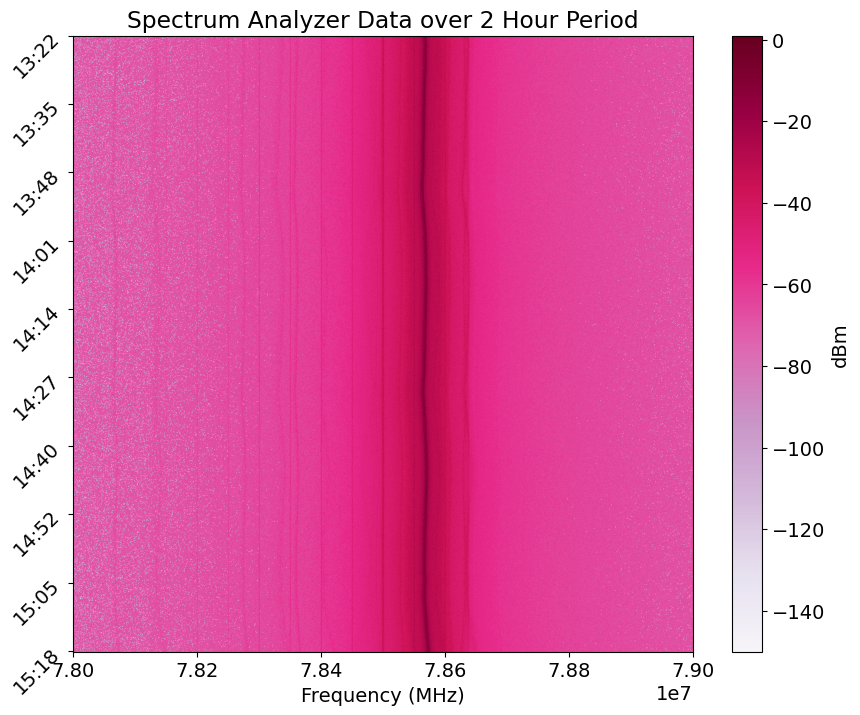

In [406]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

Z = data_filtered.values
timestamps['Timestamp'] = pd.to_datetime(timestamps['Timestamp']).dt.strftime('%H:%M')

plt.figure(figsize=(10, 8))
plt.imshow(Z, aspect='auto', cmap='PuRd', extent=[MHz.min(), MHz.max(), Z.shape[0], 0])
plt.colorbar(label='dBm')  # Show color scale
plt.xlabel('Frequency (MHz)')
num_ticks = 10  # Number of y-ticks to display
y_ticks = np.linspace(0, Z.shape[0]-1, num_ticks, dtype=int)
y_labels = timestamps.iloc[y_ticks, 0].values
plt.yticks(y_ticks, y_labels, rotation=45)

plt.title('Spectrum Analyzer Data over 2 Hour Period')
plt.show()